In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
mpl.use("Cairo")  # for saving SVGs that Affinity Designer can parse

import candas as can
import gumbi as gmb
from candas.test import FluorescenceData, QuantStudio

import pathlib as pl
code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'
graph_pth.mkdir(exist_ok=True)

gen_pth = fig_pth / 'generated'
gen_pth.mkdir(exist_ok=True)

plt.style.use(str(can.style.breve))

%config InlineBackend.figure_format = 'retina'

In [2]:
from utils import savefig

In [3]:
width = 7.08
height = 1.25
figsize = (width, height)
ticklabelsize = 6
labelsize = 8
titlesize = labelsize

# Set rcParams for plotting
mpl.rc("xtick", labelsize=ticklabelsize)
mpl.rc("ytick", labelsize=ticklabelsize)
mpl.rc("axes", labelsize=labelsize, titlesize=titlesize, linewidth=0.5)

mar_l = 0.11
mar_r = 0.15
mar_t = 0.5
mar_b = 2.5


def format_fig(
    fig, figsize=figsize, mar_l=mar_l, mar_r=mar_r, mar_t=mar_t, mar_b=mar_b, **kwargs
):
    """Adjust margins of subplots using figsize"""
    height, width = figsize
    fig.set_size_inches(figsize)

    plt.subplots_adjust(
        left=mar_l / width,
        right=1 - mar_r / width,
        top=1 - mar_t / height,
        bottom=mar_b / height,
        **kwargs
    )

    for ax in fig.get_axes():
        ax.tick_params(which="both", length=1.0, width=0.5)

# JG075F: L-MMMMx blocker tripartite competition matrix

In [4]:
cmax = 50

JG075F = (
    QuantStudio(
        data_pth / "JG075F L-MMMMx blocker tripartite competition matrix.xlsx", "JG075F"
    )
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax)
    .invert_fluorophore("FAM")
)

# Denote reaction conditions
JG075F.reactions.wide = (
    JG075F.reactions.wide.drop(columns=["Sample"]).merge(
        pd.read_csv(data_pth / "JG075F Plate Map.csv"), on="Well"
    )
    #     .assign(lg10_Blocker = lambda df: np.log10(df['Blocker μM']))
    #     .replace({'lg10_Blocker': {-np.inf: -2}})
    #     .drop(columns=['CT','lg10_Copies','Target'])
)


JG075F.reactions.neaten()
JG075F.extract_endpoints(cmax=cmax)
endpoints = JG075F.endpoints
JG075F.reactions

,Experiment,Well,Target,lg10_Copies,Outlier,WellPosition,Copies,Reporter,Task,Comments,...,Reaction,WT_lg10_Copies,SNV_lg10_Copies,Blocker μM,WellName,Sample,Blocker,Cycle,Fluorescence,Corr_Fluorescence
0,JG075F,1,FAM,-inf,False,A1,0.0,FAM,UNKNOWN,,...,0,1,-2,0.0,A1,JG075F_001,L-MMMMx,1,0.000313,0.002408
1,JG075F,1,HEX,-inf,False,A1,0.0,HEX,UNKNOWN,,...,1,1,-2,0.0,A1,JG075F_001,L-MMMMx,1,-0.001171,0.000397
2,JG075F,1,FAM,-inf,False,A1,0.0,FAM,UNKNOWN,,...,0,1,-2,0.0,A1,JG075F_001,L-MMMMx,2,0.001418,0.001183
3,JG075F,1,HEX,-inf,False,A1,0.0,HEX,UNKNOWN,,...,1,1,-2,0.0,A1,JG075F_001,L-MMMMx,2,-0.001190,0.000229
4,JG075F,1,FAM,-inf,False,A1,0.0,FAM,UNKNOWN,,...,0,1,-2,0.0,A1,JG075F_001,L-MMMMx,3,0.000909,0.001057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44755,JG075F,384,HEX,-inf,False,P24,0.0,HEX,UNKNOWN,,...,745,8,7,10.0,P24,JG075F_384,L-MMMMx,58,0.917827,0.586347
44756,JG075F,384,FAM,-inf,False,P24,0.0,FAM,UNKNOWN,,...,744,8,7,10.0,P24,JG075F_384,L-MMMMx,59,0.018171,0.004682
44757,JG075F,384,HEX,-inf,False,P24,0.0,HEX,UNKNOWN,,...,745,8,7,10.0,P24,JG075F_384,L-MMMMx,59,0.922703,0.589323
44758,JG075F,384,FAM,-inf,False,P24,0.0,FAM,UNKNOWN,,...,744,8,7,10.0,P24,JG075F_384,L-MMMMx,60,0.016668,0.006137


In [5]:
nonblank_endpoints = endpoints.query("SNV_lg10_Copies > 0")

ds = gmb.DataSet(nonblank_endpoints, outputs=["SignalDifference"])
gp = gmb.GP(ds).fit(
    continuous_dims=["WT_lg10_Copies", "SNV_lg10_Copies", "Blocker μM"],
    linear_dims=["WT_lg10_Copies", "SNV_lg10_Copies", "Blocker μM"],
)

Saving fig_ED1Ei__weak_yaksha in /home/john/projects/can-manuscript/fig_ED1__shy_quokka/graphics: [.svg] [.png] done


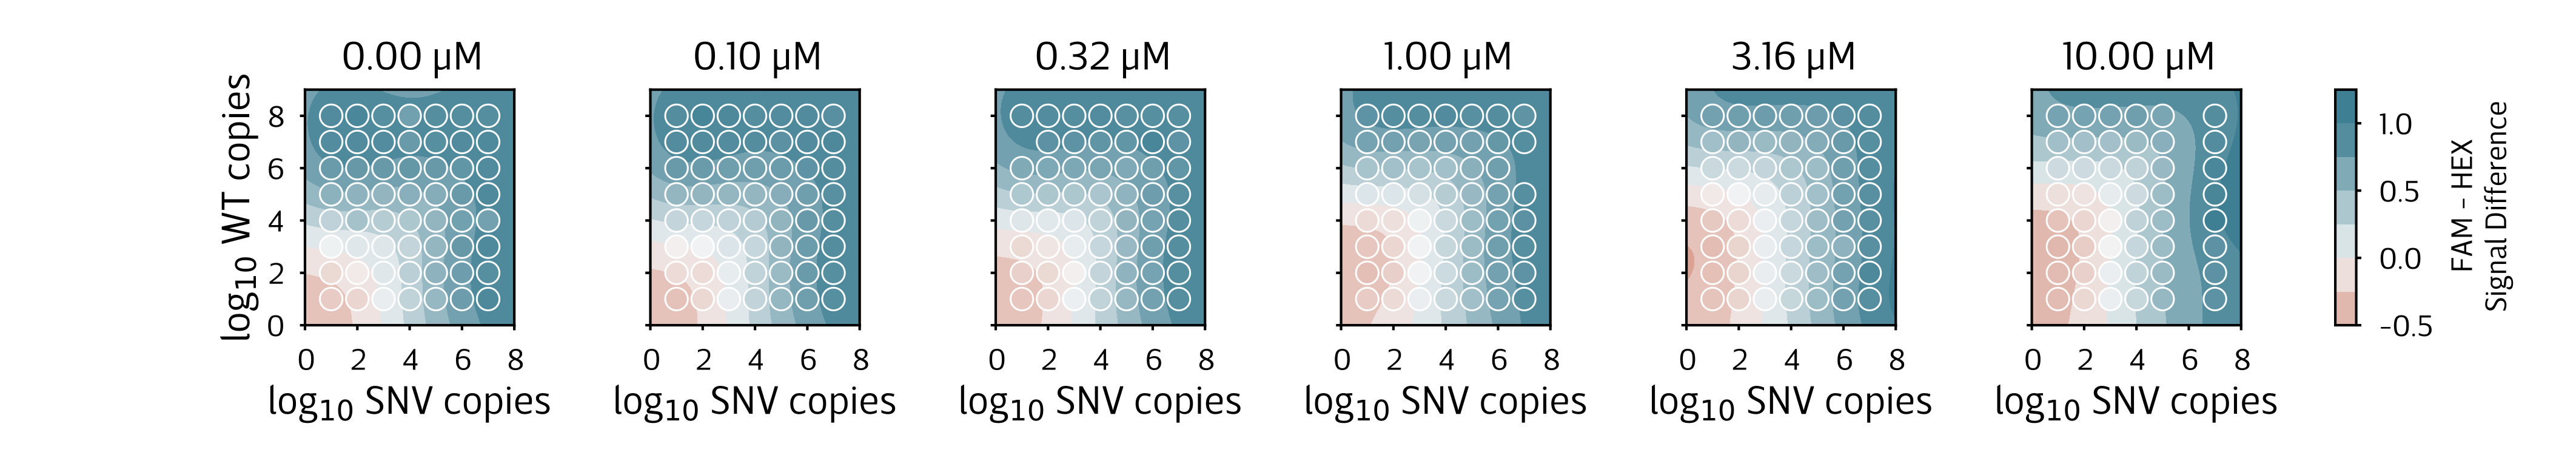

In [ ]:
hue = "SignalDifference"
extent = np.max(np.abs(nonblank_endpoints[hue]))
norm = mpl.colors.Normalize(vmin=-extent, vmax=+extent)
norm = mpl.colors.Normalize(vmin=-1, vmax=+1)
palette = sns.diverging_palette(20, 220)  # , as_cmap=True)
cmap = sns.diverging_palette(20, 220, as_cmap=True)

g = sns.relplot(
    data=nonblank_endpoints,
    col="Blocker μM",
    x="SNV_lg10_Copies",
    y="WT_lg10_Copies",
    hue="SignalDifference",
    hue_norm=norm,
    palette=cmap,
    legend=False,
    kind="scatter",
    height=2,
    aspect=1.0,
    s=20,
    zorder=10,
    facet_kws={"margin_titles": True, "despine": False},
)

# g.refline(y=0, color='k', linestyle=':', zorder=-11)
g.set_titles(
    col_template="{col_name:.2f} μM",
    row_template="{row_name}",
    fontsize=titlesize,
    pad=titlesize / 2,
)
g.set(xticks=[0, 2, 4, 6, 8])

for i, (col_val, ax) in enumerate(g.axes_dict.items()):
    ax.set_aspect("equal")
    ax.set(yticks=[0, 2, 4, 6, 8], xticks=[0, 2, 4, 6, 8], ylim=[0, 9], xlim=[0, 8])

    at = gp.parray(**{"Blocker μM": col_val})
    limits = gp.parray(SNV_lg10_Copies=[0, 8], WT_lg10_Copies=[0, 9])
    XY = gp.prepare_grid(at=at, limits=limits)
    SNV = XY["SNV_lg10_Copies"]
    WT = XY["WT_lg10_Copies"]
    sig = gp.predict_grid(with_noise=False)

    plt.sca(ax)
    pc = gmb.ParrayPlotter(x=SNV, y=WT, z=sig)(
        plt.contourf, cmap=cmap, norm=norm, zorder=-10
    )

    ax.set_xlabel(r"log$_{10}$ SNV copies", labelpad=ticklabelsize / 4)
    ax.set_ylabel(r"log$_{10}$ WT copies", labelpad=ticklabelsize / 4)

    if i == len(g.axes_dict) - 1:
        cax = ax.inset_axes([1.45, 0.0, 0.1, 1], transform=ax.transAxes)
        plt.colorbar(
            pc,
            cax=cax,
            label="Signal\nDifference",
            ticks=[-1, -0.5, 0, 0.5, 1],
            format="%.1f",
        )
        cax.yaxis.set_tick_params(labelsize=ticklabelsize, length=1.0, width=0.5)
        cax.set_ylabel(
            "FAM - HEX\nSignal Difference",
            ha="center",
            va="top",
            fontsize=ticklabelsize,
        )

format_fig(
    plt.gcf(),
    figsize=(width, height),
    mar_l=0.148,
    mar_r=0.1625,
    mar_t=mar_t * 2,
    mar_b=mar_b * 0.65,
    wspace=0.65)

savefig(plt.gcf(), alias="weak_yaksha")

/home/john/mambaforge/envs/can_manuscript/lib/python3.9/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


Saving fig_ED1Eii__big_zebra in /home/john/projects/can-manuscript/fig_ED1__shy_quokka/graphics: [.svg] [.png] done


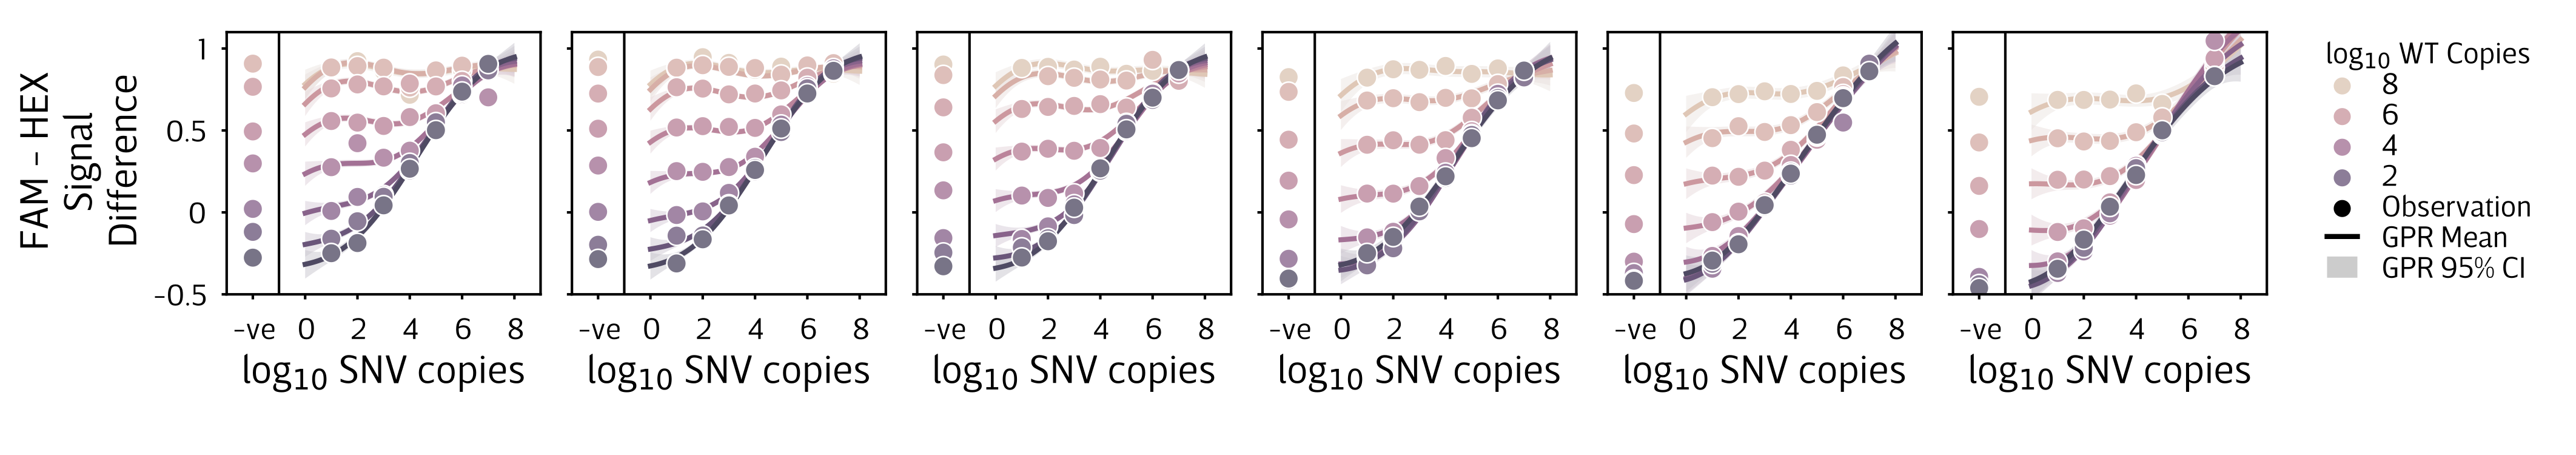

In [ ]:
pal = sns.color_palette("ch:s=-.2,r=.6", n_colors=9)

g = sns.FacetGrid(
    data=nonblank_endpoints,
    col="Blocker μM",
    height=2,
    aspect=1,
    **{"margin_titles": True, "despine": False},
)

spotsize = 15

for col_val, ax in g.axes_dict.items():
    for copies, rgb in zip(np.arange(1, 9)[::-1], pal[1:]):
        at = gp.parray(**{"Blocker μM": col_val, "WT_lg10_Copies": copies})
        limits = gp.parray(SNV_lg10_Copies=[0, 8])
        X = gp.prepare_grid(at=at, limits=limits)["SNV_lg10_Copies"]
        sig = gp.predict_grid(with_noise=False)

        plt.sca(ax)
        gmb.ParrayPlotter(x=X, y=sig).plot(palette=sns.light_palette(rgb), line_kws=dict(lw=1))
        
        sns.scatterplot(
            data=endpoints[
                (endpoints["Blocker μM"] == col_val)
                & (endpoints["WT_lg10_Copies"] == copies)
            ],
            x="SNV_lg10_Copies",
            y="SignalDifference",
            s=spotsize,
            color=sns.light_palette(rgb)[-3],
            ax=ax,
        )
        # ax.set_title(f"{col_val:.2f} μM", fontsize=titlesize)
        ax.set_title("")
    ax.axvline(-1, color="k", lw=0.5)

lax = g.axes[0, 0]
lax.set_ylabel("FAM - HEX\nSignal\nDifference", labelpad=ticklabelsize/4, fontsize=labelsize)

rax = g.axes[0, -1]

xl = rax.get_xlim()
yl = rax.get_ylim()

# Create dummy legend elements
dummies = []
labels = []
for copies, rgb in zip([2, 4, 6, 8][::-1], pal[1::2]):
    dummies.append(
        rax.scatter(
            x=[-10],
            y=[-10],
            marker="o",
            color=sns.light_palette(rgb)[-3],
            s=spotsize,
            edgecolor="w",
            linewidths=0.5,
        )
    )
    labels.append(str(copies))

dummies.append(
    rax.scatter(
        x=[-10],
        y=[-10],
        marker="o",
        color="k",
        s=spotsize,
        edgecolor="w",
        linewidths=0.5,
    )
)
labels.append("Observation")

dummies.append(rax.plot([-10, -10], [-10, -10], color="k", linewidth=1)[0])
labels.append("GPR Mean")

dummies.append(
    rax.fill_between(
        [-10, -10], [-10, -10], [-10, -10], color="k", alpha=0.2, edgecolor="none"
    )
)
labels.append("GPR 95% CI")

rax.set_xlim(xl)
rax.set_ylim(yl)

# Add legend to the right-most axis
rax.legend(
    dummies,
    labels,
    title=r"log$_{10}$ WT Copies",
    loc="center left",
    bbox_to_anchor=(1.1, 0.5),
    frameon=False,
    fontsize=ticklabelsize,
    title_fontsize=ticklabelsize,
    handlelength=1.0,
    labelspacing=0.05,
)

g.set_xticklabels(fontsize=ticklabelsize)
g.set_yticklabels(fontsize=ticklabelsize)
g.set_xlabels(r"log$_{10}$ SNV copies", fontsize=labelsize, labelpad=ticklabelsize/4)

g.set(
    yticks=[-0.5, 0, 0.5, 1],
    yticklabels=[-0.5, 0, 0.5, 1],
    xticks=[-2, 0, 2, 4, 6, 8],
    xticklabels=["-ve", 0, 2, 4, 6, 8],
    ylim=[-0.5, 1.1],
    xlim=[-3, 9],
)


# plt.tight_layout()

format_fig(plt.gcf(), wspace=0.1)


savefig(plt.gcf(), alias="big_zebra")

In [ ]:
pal = sns.color_palette("ch:s=-.2, r=.6", n_colors=9)

g = sns.FacetGrid(
    data=nonblank_endpoints,
    col="Blocker μM",
    height=4,
    aspect=0.9,
    **{"margin_titles": True, "despine": False}
)

for col_val, ax in g.axes_dict.items():
    for copies, rgb in zip(np.arange(1, 9)[::-1], pal[1:]):
        at = gp.parray(**{"Blocker μM": col_val, "WT_lg10_Copies": copies})
        limits = gp.parray(SNV_lg10_Copies=[0, 8])
        X = gp.prepare_grid(at=at, limits=limits)["SNV_lg10_Copies"]
        sig = gp.predict_grid(with_noise=True)

        zero = endpoints[
            (endpoints["Blocker μM"] == col_val)
            & (endpoints["WT_lg10_Copies"] == copies)
            & (endpoints["SNV_lg10_Copies"] == -2)
        ]["SignalDifference"]

        if len(zero) > 0:
            plt.sca(ax)
            gmb.ParrayPlotter(x=X, y=sig.dist.sf(zero)).plot(
                palette=sns.light_palette(rgb)
            )

            LOD_idx = np.argmax(sig.dist.sf(zero) > 0.95)
            if LOD_idx > 0:
                LOD = X[LOD_idx]
                crossing_pt = sig.dist.sf(zero)[LOD_idx]
                color = sns.light_palette(rgb)[-2]
                plt.plot([LOD, LOD], [0, crossing_pt], color=color, ls="--")

g.set(xticks=[0, 2, 4, 6, 8])
plt.tight_layout()

savefig(plt.gcf(), alias="big_zebra", extra='alt')